In [1]:
from scipy.io import loadmat
lfp_buz_features = loadmat('lfp_buz_features_rgs14.mat')

## EEG Bands and EMG Like Signals

In [2]:
import pandas as pd
import numpy as np

lfp_matrix = np.array(lfp_buz_features['lfpFeatures'])

numColumns = len(lfp_matrix[0])

delta_pfc_df = pd.DataFrame(lfp_matrix[:, 0], columns=["DeltaPFC"])
theta_hpc_df = pd.DataFrame(lfp_matrix[:, 1], columns=["ThetaHPC"])
beta_pfc_df = pd.DataFrame(lfp_matrix[:, 2], columns=["BetaPFC"])
gamma_hpc_df = pd.DataFrame(lfp_matrix[:, 3], columns=["GammaHPC"])
emg_like_df = pd.DataFrame(lfp_matrix[:, 4], columns=["EMGLike"])

epsilon_value = 0.0001
timesteps = 10542

In [3]:
delta_pfc = delta_pfc_df['DeltaPFC'].values
theta_hpc  = theta_hpc_df['ThetaHPC'].values

# delta_pfc = delta_pfc[delta_pfc != 0]
delta_pfc = np.where(delta_pfc == 0, epsilon_value, delta_pfc)
# theta_hpc = theta_hpc[theta_hpc != 0]
theta_hpc = np.where(theta_hpc == 0, epsilon_value, theta_hpc)

delta_pfc_by_theta_hpc = delta_pfc / theta_hpc

emg_like = emg_like_df.EMGLike.values
# emg_like = emg_like[emg_like != 0]
emg_like = np.where(emg_like == 0, epsilon_value, emg_like)

## Bands
- Nx4 data array, where N is the number of epochs, and columns refer to Delta PFC, Theta HPC, Delta/Theta and EMG

In [4]:
rgs_14_bands = np.column_stack([
    delta_pfc, 
    theta_hpc, 
    delta_pfc_by_theta_hpc, 
    emg_like, 
])

In [5]:
rgs_14_bands

array([[0.14977489, 0.10481071, 1.4290037 , 0.93493003],
       [0.15763617, 0.11268804, 1.39887228, 0.92934066],
       [0.16509083, 0.12095128, 1.36493664, 0.91670823],
       ...,
       [0.38752742, 0.55695679, 0.6957944 , 0.09506661],
       [0.400658  , 0.51908918, 0.7718481 , 0.08132514],
       [0.4145541 , 0.48116965, 0.86155496, 0.07903146]])

In [6]:
np.min(rgs_14_bands, axis=0)

array([0.0001    , 0.0001    , 0.00021234, 0.0001    ])

In [7]:
np.max(rgs_14_bands, axis=0)

array([1.00000000e+00, 1.00000000e+00, 9.04189424e+03, 1.00000000e+00])

In [8]:
import matplotlib.pyplot as plt
num_bins = int(np.sqrt(timesteps))

Text(0.5, 1.0, 'Histogram of delta pfc')

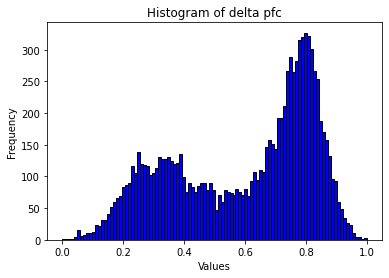

In [9]:
plt.hist(delta_pfc, bins=num_bins, color='blue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of delta pfc')

Text(0.5, 1.0, 'Histogram of theta hpc')

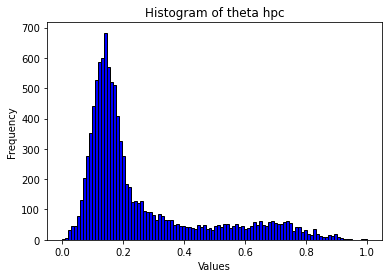

In [10]:
plt.hist(theta_hpc, bins=num_bins, color='blue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of theta hpc')

Text(0.5, 1.0, 'Histogram of emg like')

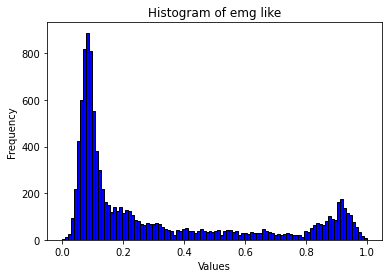

In [11]:
plt.hist(emg_like, bins=num_bins, color='blue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of emg like')

## Normalize Delta PFC By Theta HPC

Text(0.5, 1.0, 'Histogram of delta_pfc_by_theta_hpc')

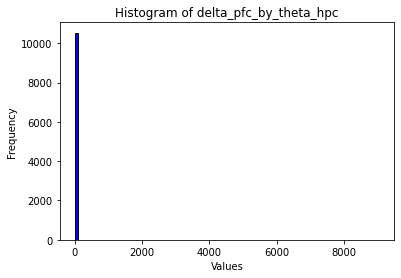

In [12]:
plt.hist(delta_pfc_by_theta_hpc, bins=num_bins, color='blue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of delta_pfc_by_theta_hpc')

In [13]:
print(f"Total number of values: {len(delta_pfc_by_theta_hpc)}")
print(f"Min: {np.min(delta_pfc_by_theta_hpc)}")
print(f"Max: {np.max(delta_pfc_by_theta_hpc)}")

print(f"Median: {np.median(delta_pfc_by_theta_hpc)}")

threshold = 1.0

print(f"Number of values greater than {threshold}: {len(delta_pfc_by_theta_hpc[delta_pfc_by_theta_hpc > threshold])}")

Total number of values: 10542
Min: 0.00021233580582612056
Max: 9041.894242541466
Median: 3.9673140258333834
Number of values greater than 1.0: 7926


In [14]:
outlier_threshold = 1.0

min_value = np.min(delta_pfc_by_theta_hpc)
max_value = np.max(delta_pfc_by_theta_hpc)

log_transformed_data = np.log1p(delta_pfc_by_theta_hpc + 1)
normalized_delta_pfc_by_theta_hpc = (log_transformed_data - min_value) / (max_value - min_value)

# Check the range of values after normalization
print("Min value after normalization:", np.min(normalized_delta_pfc_by_theta_hpc))
print("Max value after normalization:", np.max(normalized_delta_pfc_by_theta_hpc))

Min value after normalization: 7.664776922914855e-05
Max value after normalization: 0.0010074916575478533


Text(0.5, 1.0, 'Histogram of delta_pfc_by_theta_hpc')

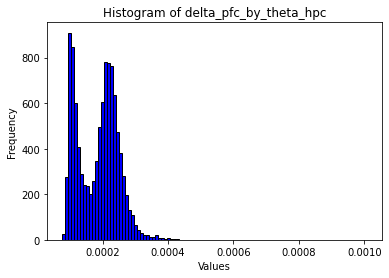

In [15]:
plt.hist(normalized_delta_pfc_by_theta_hpc, bins=num_bins, color='blue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of delta_pfc_by_theta_hpc')

In [16]:
print(f"Number of values greater than {0}: {len(normalized_delta_pfc_by_theta_hpc[normalized_delta_pfc_by_theta_hpc < 0.5])}")

Number of values greater than 0: 10542


## EpochsLinked
- Nx4 data array, where N is the number of epochs, and columns are described as follows:

	- column 1: epoch ID
	- column 2: epoch index (currently not used)
	- column 3: ground truth sleep stage ID, where

				- 1 is associated with wakefulness,
				- 2 is associated with NREM sleep,
				- 3 is associated with REM sleep
	- column 4: the subject ID (used in multi-subject analysis only)

In [17]:
epoch_ids = np.arange(timesteps, dtype=int)

epoch_ids.size

10542

In [18]:
epoch_index = np.arange(timesteps, dtype=int)

epoch_index.size

10542

In [19]:
states = loadmat('states.mat')

states.keys()

dict_keys(['__header__', '__version__', '__globals__', 'downsampledStates', 'keys', 'None', '__function_workspace__'])

In [20]:
states['downsampledStates']

array([[0, 0, 0, ..., 4, 4, 4]], dtype=uint8)

In [21]:
ground_truth_sleep_stage_id = states['downsampledStates'].astype(int)

ground_truth_sleep_stage_id = ground_truth_sleep_stage_id.flatten()

In [22]:
ground_truth_sleep_stage_id

array([0, 0, 0, ..., 4, 4, 4])

In [23]:
subject_id = np.ones(timesteps, dtype=int)

subject_id.size

10542

In [24]:
epochs_linked = np.column_stack([epoch_ids, 
                                 epoch_index, 
                                 ground_truth_sleep_stage_id,
                                 subject_id
                                ])

# epochs_linked.shape

In [25]:
epochs_linked.shape

(10542, 4)

## EpochTime
- Nx3 data array, where N is the number of epochs, and columns are described as follows:

	- column 1: epoch ID
	- column 2: recording mode (i.e. baseline or recovery), where
    
			   - 1 is associated with baseline,
			   - 2 is associated with recovery (after sleep deprivation)
	- column 3: the epoch date-time

In [26]:
recording_mode = np.ones(timesteps).astype('<f8')

In [27]:
start_value = 41137.2918055555
step_size = 8.234392028162487e-05

time = np.arange(start_value, start_value + step_size * timesteps, step_size).astype('<f8')

time = time[:10542]

time.shape

(10542,)

In [28]:
epoch_time = np.column_stack([epoch_ids.astype('<f8'), recording_mode, time])

epoch_time

array([[0.00000000e+00, 1.00000000e+00, 4.11372918e+04],
       [1.00000000e+00, 1.00000000e+00, 4.11372919e+04],
       [2.00000000e+00, 1.00000000e+00, 4.11372920e+04],
       ...,
       [1.05390000e+04, 1.00000000e+00, 4.11381596e+04],
       [1.05400000e+04, 1.00000000e+00, 4.11381597e+04],
       [1.05410000e+04, 1.00000000e+00, 4.11381598e+04]])

In [29]:
np.savez("rgs14.npz", d=rgs_14_bands, epochsLinked=epochs_linked, epochTime=epoch_time)